In [1]:
import sys  
sys.path.insert(0, '../utils')
import warnings
warnings.filterwarnings("ignore")

from fsdd import TorchFSDD, collate_fn
from display import show_results
from helpers import TrimMFCCs, Standardize
import math, itertools, librosa, numpy as np, sigment as sig, sklearn.preprocessing, sklearn.metrics
import matplotlib.pyplot as plt, librosa.display; plt.style.use('ggplot');
from matplotlib.ticker import FuncFormatter, MaxNLocator
from tqdm.notebook import tqdm

import torch, torchaudio, torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Set CUDA device (if available)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set seed, sample rate and labels
torch.manual_seed(0)
sr = 8000
fsdd_labels = range(10)

In [2]:
# Set number of MFCCs to 39
n_mfcc = 39

In [3]:
# Preprocessing transformations
transform = torchvision.transforms.Compose([
    torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=n_mfcc+1),
    TrimMFCCs(),
    Standardize(),
])

In [4]:
# Set batch size, shuffling and number of workers
loader_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}

# Create training, validation and test set batch iterators
training_set = TorchFSDD('train', transform=transform)
training_generator = torch.utils.data.DataLoader(training_set, collate_fn=collate_fn, **loader_params)
validation_set = TorchFSDD('validation', transform=transform)
validation_generator = torch.utils.data.DataLoader(validation_set, collate_fn=collate_fn, **loader_params)
test_set = TorchFSDD('test', transform=transform)
test_generator = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set), num_workers=0)

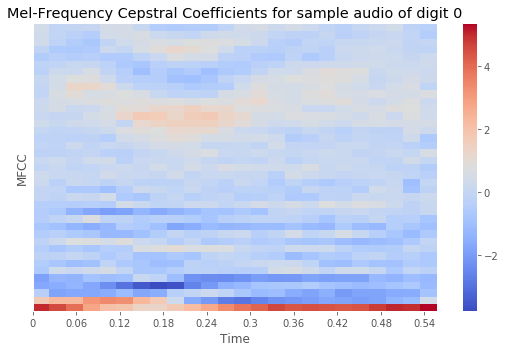

In [5]:
# Retrieve MFCCs for a sample training digit
mfccs, label = next(iter(training_set))
X = mfccs.squeeze().numpy()

# Plot the MFCCs for the digit
plt.figure(figsize=(8, 5))
librosa.display.specshow(X, x_axis='time')
plt.colorbar()
plt.title(f'Mel-Frequency Cepstral Coefficients for sample audio of digit {label}')
plt.ylabel('MFCC')
plt.tight_layout()
plt.show()

In [6]:
# Create model
class LSTM(nn.Module):
    def __init__(self, hidden_size, fc_size):
        super().__init__()
        self.model = nn.ModuleDict({
            # Bidirectional single-layer LSTM
            'lstm': nn.LSTM(n_mfcc, hidden_size, num_layers=1, batch_first=True, bidirectional=True),
            # Fully-connected classification layer
            'fc1': nn.Linear(hidden_size*2, fc_size),
            # (Pre-)Softmax layer for digit probabilities
            'fc2': nn.Linear(fc_size, len(fsdd_labels)),
        })
 
    def forward(self, x, x_lengths):
        """
        Parameters
        ----------
        x: Tensor (B x T_max x D)
            Batch tensor of padded MFCC sequences.
        
        x_lengths: Tensor (B)
            Tensor of lengths for each sequence in the batch.
        """
        
        # Retrieve batch size
        batch_size = len(x)

        # Pack the padded Tensor into a PaddedSequence
        x_packed = pack_padded_sequence(x, x_lengths, batch_first=True)
        
        # Pass the PackedSequence through the bidirectional LSTM cell (x = final hidden state vectors)
        x_packed, (x, cell) = self.model['lstm'](x_packed)
        x = F.dropout(x, training=self.training)
        # Shape (x): n_layers*2 x B x h_dim
        
        # Reshape the final hidden state vectors
        x = x.transpose(1, 2).reshape(-1, batch_size).transpose(1, 0)
        # Shape: B x h_dim*2
        
        # Pass final hidden state vectors through the fully-connected ReLU layer
        x = F.relu(self.model['fc1'](x))
        x = F.dropout(x, training=self.training)
        # Shape: B x fc_dim
        
        # Pass to log-softmax layer for classification
        return F.log_softmax(self.model['fc2'](x))
        # Shape: B x 10

In [7]:
# Set base hyper-parameters
lr = 0.002
epochs = 15

best = (None, None, {}, -1)
for i, (hidden_size, fc_size) in enumerate(itertools.product(*[[50, 100, 250, 500]]*2)):
    pbar = tqdm(total=epochs, position=i, leave=True, ncols='100%')
    pbar.set_description("hidden_size={}, fc_size={} | epoch 1/{} | acc: train={:.2f}%, val={:.2f}%".format(
        hidden_size, fc_size, epochs, 0, 0))

    # Configure model hyper-parameters and send model to GPU
    model = LSTM(hidden_size=hidden_size, fc_size=fc_size).to(device)

    # Set loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Keep track of training and validation accuracies
    acc_history = {'train': np.zeros(epochs), 'val': np.zeros(epochs)}
    
    for epoch in range(epochs):
        # Training
        model.train()
        n_train, train_acc = 0, 0.
        for batch, lengths, labels in training_generator:
            # Transfer tensors to GPU
            batch, lengths, labels = batch.to(device), lengths.to(device), labels.to(device)

            # Reset the optimizer
            optimizer.zero_grad()

            # Calculate predictions for batch
            y = model(batch, lengths)
            y_pred = torch.argmax(y, dim=1)

            # Calculate and back-propagate loss
            loss = criterion(y, labels)
            loss.backward()
            # Update the optimizer
            optimizer.step()

            # Calculate training accuracy
            n_train += len(batch)
            train_acc += (y_pred == labels).sum().item()
        train_acc /= n_train

        # Validation 
        model.eval()
        n_val, val_acc = 0, 0.
        with torch.no_grad():
            for batch, lengths, labels in validation_generator:
                # Transfer to GPU
                batch, lengths, labels = batch.to(device), lengths.to(device), labels.to(device)

                # Calculate predictions for batch
                y = model(batch, lengths)
                y_pred = torch.argmax(y, dim=1)

                # Calculate validation accuracy
                n_val += len(batch)
                val_acc += (y_pred == labels).sum().item()
            val_acc /= n_val
            
        # Store accuracy history
        acc_history['train'][epoch] = train_acc
        acc_history['val'][epoch] = val_acc
        
        # Update progress bar
        pbar.update(1)
        pbar.set_description("hidden_size={}, fc_size={} | epoch {}/{} | acc: train={:.2f}%, val={:.2f}%".format(
            hidden_size, fc_size, epoch+1, epochs, train_acc * 100, val_acc * 100))
        
    if val_acc > best[-1]:
        # Save the model and accuracy history
        model_file = f'../models/lstm-{hidden_size}-{fc_size}.pt'
        history_file = f'../models/lstm-{hidden_size}-{fc_size}-history.npz'
        torch.save(model, model_file)
        np.savez(history_file, train=acc_history['train'], val=acc_history['val'])
        
        # Update the best model
        best = (model_file, history_file, {'hidden_size': hidden_size, 'fc_size': fc_size}, val_acc)
        
    pbar.close()

In [8]:
# Display the best model
print(f'Best model: {best[2]}')

# Load the best model and accuracy history
model = torch.load(best[0]).to(device)
acc_history = np.load(best[1])
print('Training accuracy: {:.2f}%'.format(acc_history['train'][-1] * 100))
print('Validation accuracy: {:.2f}%'.format(acc_history['val'][-1] * 100))

Best model: {'hidden_size': 500, 'fc_size': 50}
Training accuracy: 98.97%
Validation accuracy: 98.25%


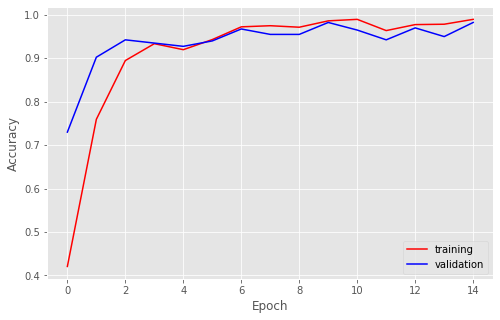

In [9]:
# Plot the training and validation accuracy history
plt.figure(figsize=(8, 5))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(acc_history['train'], c='r', label='training')
plt.plot(acc_history['val'], c='b', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Classify test recordings.

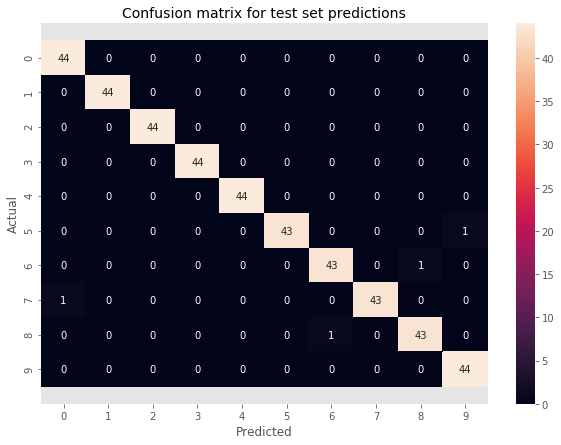

Accuracy: 99.09%


In [10]:
# Toggle evaluation mode
model.eval()

# Retrieve test set as a single batch
batch, lengths, labels = next(iter(test_generator))
batch, lengths, labels = batch.to(device), lengths.to(device), labels.to(device)

# Calculate predictions for test set
y = model(batch, lengths)
y_pred = torch.argmax(y, dim=1)

# Calculate confusion matrix and accuracy
cm = sklearn.metrics.confusion_matrix(labels.numpy(), y_pred.detach().numpy(), labels=fsdd_labels)
acc = np.diag(cm).sum() / cm.sum()
show_results(acc, cm, dataset='test', labels=fsdd_labels)